# Random Forest

The `conifer` package was created out of `hls4ml`, providing a similar set of features but specifically targeting inference of random forest. In this notebook we will train a `RandomForestClassifier` with scikit-learn, using the MNIST dataset. Then we will convert the model using `conifer`, and run bit-accurate prediction and synthesis.

`conifer` is available from GitHub [here](https://github.com/thesps/conifer), and we have a publication describing the inference implementation and performance in detail [here](https://iopscience.iop.org/article/10.1088/1748-0221/15/05/P05026/pdf).


In [1]:
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import accuracy_score
import joblib
import conifer
import plotting
import matplotlib.pyplot as plt
import os
os.environ['XILINX_VIVADO']='/home/rrk307/Xilinx/Vivado/2018.3'
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']
np.random.seed(0)

runtime module could not be imported. Interacting with FPUs will not be possible.


### Random Forest MNIST

In [2]:
#https://www.kaggle.com/code/ashwani07/mnist-classification-using-random-forest/notebook
import pandas as pd
import os
train = pd.read_csv("/home/rrk307/MNIST_dataset/train.csv")
test = pd.read_csv("/home/rrk307/MNIST_dataset/test.csv")

In [3]:
from sklearn.ensemble import RandomForestClassifier  #Random Forest algorithm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV 
from sklearn.model_selection import cross_val_score
print ("Training dataset has %i observations and %i variables" %(train.shape[0], train.shape[1]))
print ("Testing dataset has %i observations and %i variables" %(test.shape[0], test.shape[1]))
df_x=train.iloc[:,1:]
df_y=train.iloc[:,0]
X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=0)
(X_train, X_test, y_train, y_test) = X_train.values, X_test.values, y_train.values, y_test.values
print(X_train.shape)
print(X_test.shape)
rf=RandomForestClassifier(n_estimators=3, max_depth=5, random_state=0)
rf.fit(X_train,y_train)
pred=rf.predict(X_test)
print ("Classification Report")
print(classification_report(y_test, pred))
print ("Confusion Report")
print(confusion_matrix(y_test, pred))

Training dataset has 42000 observations and 785 variables
Testing dataset has 28000 observations and 784 variables
(33600, 784)
(8400, 784)
Classification Report
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       813
           1       0.79      0.97      0.87       961
           2       0.74      0.72      0.73       860
           3       0.70      0.69      0.70       863
           4       0.61      0.62      0.61       827
           5       0.70      0.37      0.48       756
           6       0.79      0.76      0.77       841
           7       0.65      0.73      0.68       899
           8       0.66      0.66      0.66       768
           9       0.52      0.52      0.52       812

    accuracy                           0.70      8400
   macro avg       0.70      0.69      0.69      8400
weighted avg       0.70      0.70      0.69      8400

Confusion Report
[[727   1  11   7   8   4  13   6  30   6]
 [  0 930   7   4  

#### Profiling Accuracy for various RF architecture

In [4]:
import numpy as np
from sklearn.utils import shuffle
X_shuffle,y_shuffle = shuffle(X_train,y_train)
X_train = X_shuffle[0:50000]
y_train = y_shuffle[0:50000]

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
train_acc = {}
val_acc = {}
nodes_count = {}
leaves_count = {}
rf_clf = {}
for n_tree in range(3,20,2):
    rf_clf[n_tree] = RandomForestClassifier(n_estimators=n_tree, max_depth=5)

    y_train_pred = cross_val_predict(rf_clf[n_tree], X_train, y_train, cv=2)
    rf_clf[n_tree].fit(X_train, y_train)

    from sklearn.model_selection import cross_val_score
    train_acc[n_tree] = np.mean(cross_val_score(rf_clf[n_tree], X_train, y_train, cv=2, scoring="accuracy"))
    val_acc[n_tree] = np.mean(cross_val_score(rf_clf[n_tree], X_test, y_test, cv=2, scoring="accuracy"))
    nodes_count[n_tree] = [tree_i.tree_.node_count for tree_i in rf_clf[n_tree].estimators_]
    leaves_count[n_tree] = [tree_i.tree_.n_leaves for tree_i in rf_clf[n_tree].estimators_]

Training accuracy:  {3: 0.7064880952380952, 5: 0.7607738095238095, 7: 0.7898809523809524, 9: 0.7910119047619049, 11: 0.8079166666666666, 13: 0.8256547619047618, 15: 0.8255059523809524, 17: 0.8263392857142857, 19: 0.8326190476190476}
Testing accuracy:  {3: 0.6801190476190476, 5: 0.7554761904761905, 7: 0.7698809523809524, 9: 0.7945238095238095, 11: 0.8070238095238096, 13: 0.8160714285714286, 15: 0.8139285714285713, 17: 0.8235714285714286, 19: 0.8335714285714286}
Nodes count:  {3: [63, 63, 63], 5: [63, 63, 63, 63, 63], 7: [63, 63, 63, 63, 63, 63, 63], 9: [63, 63, 63, 63, 63, 63, 63, 63, 63], 11: [63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63], 13: [63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63], 15: [63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63], 17: [63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63], 19: [63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63, 63]}
Leaves count:  {3: [32, 32, 32], 5: [32, 32, 32, 32, 32], 7: [32, 32, 32, 

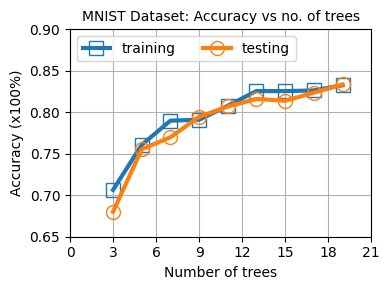

In [5]:
print('Training accuracy: ',train_acc)
print('======================')
print('Testing accuracy: ',val_acc)
print('======================')
print('Nodes count: ',nodes_count)
print('======================')
print('Leaves count: ',leaves_count)
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(4, 3))
plt.plot(train_acc.keys(), train_acc.values(), marker = 's', markersize=10, fillstyle = 'none', linewidth=3, label = 'training')
plt.plot(val_acc.keys(), val_acc.values(), marker = 'o', markersize=10, fillstyle = 'none', linewidth=3, label = 'testing')
plt.xlabel('Number of trees', size=10)
plt.ylabel('Accuracy (x100%)', size=10)
plt.title('MNIST Dataset: Accuracy vs no. of trees', size=10)
plt.grid()
plt.yticks([0.65, 0.7, 0.75, 0.8, 0.85, 0.9], size=10)
plt.xticks(range(0,22,3), size=10)
plt.legend(ncol=2, loc='upper left')
plt.tight_layout()
plt.savefig('accuracy_rf_MNIST.pdf')
plt.show()

#### HLS of the unencrypted model.

In [6]:
cfg = conifer.backends.xilinxhls.auto_config()
# Set the output directory to something unique
cfg['OutputDir'] = 'model_MNIST_RF/conifer_prj'
cfg['XilinxPart'] = 'xc7a200tfbg676-2'   #Artix-7 FPGA
cfg['Precision'] = 'ap_fixed<8,8>'
print(cfg)
# Create and compile the model
model = conifer.converters.convert_from_sklearn(rf, cfg)
model.compile()
model.build()

f=open(cfg['OutputDir'] + '/my_prj_prj/solution1/syn/report/my_prj_csynth.rpt','r')
print(f.read())

{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_MNIST_RF/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<8,8>'}


== Vivado HLS Report for 'my_prj'
* Date:           Tue Sep 19 12:22:04 2023

* Version:        2018.3 (Build 2405991 on Thu Dec 06 23:56:15 MST 2018)
* Project:        my_prj_prj
* Solution:       solution1
* Product family: artix7
* Target device:  xc7a200tfbg676-2


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |   5.00|     4.372|        0.62|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +-----+-----+-----+-----+----------+
    |  Latency  |  Interval | Pipeline |
    | min | max | min | max |   Type   |
    +-----+-----+-----+-----+----------+
    |    7|    7|    1|    1| funct

#### Rounding the thresholds to nearest integer values before encryption. Verifying that rounding operation maintains the accuracy.

In [22]:
for i,dt in enumerate(rf.estimators_):
    print('Minimum and maximum threshold value is ',min(dt.tree_.threshold), max(dt.tree_.threshold))
        
for i,dt in enumerate(rf.estimators_):
    for j,thd in enumerate(dt.tree_.threshold):
        rf.estimators_[i].tree_.threshold[j] = int(round(thd))
        
pred=rf.predict(X_test)
print ("Classification Report")
print(classification_report(y_test, pred))
print ("Confusion Report")
print(confusion_matrix(y_test, pred))

print('Thresholds of decision trees')
for i,dt in enumerate(rf.estimators_):
    print(dt.tree_.threshold)

Minimum and maximum threshold value is  -2.0 191.5
Minimum and maximum threshold value is  -2.0 191.5
Minimum and maximum threshold value is  -2.0 208.0
Classification Report
              precision    recall  f1-score   support

           0       0.81      0.89      0.85       813
           1       0.79      0.97      0.87       961
           2       0.75      0.72      0.74       860
           3       0.70      0.69      0.70       863
           4       0.61      0.62      0.61       827
           5       0.69      0.37      0.49       756
           6       0.79      0.76      0.77       841
           7       0.64      0.73      0.68       899
           8       0.66      0.66      0.66       768
           9       0.52      0.52      0.52       812

    accuracy                           0.70      8400
   macro avg       0.70      0.69      0.69      8400
weighted avg       0.70      0.70      0.69      8400

Confusion Report
[[726   1  11   7   8   5  14   6  29   6]
 [  0 

#### Encrypt the trees and dataset using the ciphertexts generated in "McEliece Code-based Cryptography.ipynb" notebook file. 

In [5]:
ciphertexts = {-2: 1011, -1: 1019, 0: 1028, 1: 1034, 2: 1041, 3: 1055, 4: 1063, 5: 1065, 6: 1074, 7: 1084, 8: 1091, 9: 1101, 10: 1110, 11: 1112, 12: 1120, 13: 1134, 14: 1141, 15: 1147, 16: 2564, 17: 2570, 18: 2577, 19: 2591, 20: 2599, 21: 2601, 22: 2610, 23: 2620, 24: 2627, 25: 2637, 26: 2646, 27: 2648, 28: 2656, 29: 2670, 30: 2677, 31: 2683, 32: 4356, 33: 4362, 34: 4369, 35: 4383, 36: 4391, 37: 4393, 38: 4402, 39: 4412, 40: 4419, 41: 4429, 42: 4438, 43: 4440, 44: 4448, 45: 4462, 46: 4469, 47: 4475, 48: 7940, 49: 7946, 50: 7953, 51: 7967, 52: 7975, 53: 7977, 54: 7986, 55: 7996, 56: 8003, 57: 8013, 58: 8022, 59: 8024, 60: 8032, 61: 8046, 62: 8053, 63: 8059, 64: 9988, 65: 9994, 66: 10001, 67: 10015, 68: 10023, 69: 10025, 70: 10034, 71: 10044, 72: 10051, 73: 10061, 74: 10070, 75: 10072, 76: 10080, 77: 10094, 78: 10101, 79: 10107, 80: 10500, 81: 10506, 82: 10513, 83: 10527, 84: 10535, 85: 10537, 86: 10546, 87: 10556, 88: 10563, 89: 10573, 90: 10582, 91: 10584, 92: 10592, 93: 10606, 94: 10613, 95: 10619, 96: 12804, 97: 12810, 98: 12817, 99: 12831, 100: 12839, 101: 12841, 102: 12850, 103: 12860, 104: 12867, 105: 12877, 106: 12886, 107: 12888, 108: 12896, 109: 12910, 110: 12917, 111: 12923, 112: 15364, 113: 15370, 114: 15377, 115: 15391, 116: 15399, 117: 15401, 118: 15410, 119: 15420, 120: 15427, 121: 15437, 122: 15446, 123: 15448, 124: 15456, 125: 15470, 126: 15477, 127: 15483, 128: 17156, 129: 17162, 130: 17169, 131: 17183, 132: 17191, 133: 17193, 134: 17202, 135: 17212, 136: 17219, 137: 17229, 138: 17238, 139: 17240, 140: 17248, 141: 17262, 142: 17269, 143: 17275, 144: 19716, 145: 19722, 146: 19729, 147: 19743, 148: 19751, 149: 19753, 150: 19762, 151: 19772, 152: 19779, 153: 19789, 154: 19798, 155: 19800, 156: 19808, 157: 19822, 158: 19829, 159: 19835, 160: 22020, 161: 22026, 162: 22033, 163: 22047, 164: 22055, 165: 22057, 166: 22066, 167: 22076, 168: 22083, 169: 22093, 170: 22102, 171: 22104, 172: 22112, 173: 22126, 174: 22133, 175: 22139, 176: 22532, 177: 22538, 178: 22545, 179: 22559, 180: 22567, 181: 22569, 182: 22578, 183: 22588, 184: 22595, 185: 22605, 186: 22614, 187: 22616, 188: 22624, 189: 22638, 190: 22645, 191: 22651, 192: 24580, 193: 24586, 194: 24593, 195: 24607, 196: 24615, 197: 24617, 198: 24626, 199: 24636, 200: 24643, 201: 24653, 202: 24662, 203: 24664, 204: 24672, 205: 24686, 206: 24693, 207: 24699, 208: 28164, 209: 28170, 210: 28177, 211: 28191, 212: 28199, 213: 28201, 214: 28210, 215: 28220, 216: 28227, 217: 28237, 218: 28246, 219: 28248, 220: 28256, 221: 28270, 222: 28277, 223: 28283, 224: 29956, 225: 29962, 226: 29969, 227: 29983, 228: 29991, 229: 29993, 230: 30002, 231: 30012, 232: 30019, 233: 30029, 234: 30038, 235: 30040, 236: 30048, 237: 30062, 238: 30069, 239: 30075, 240: 31492, 241: 31498, 242: 31505, 243: 31519, 244: 31527, 245: 31529, 246: 31538, 247: 31548, 248: 31555, 249: 31565, 250: 31574, 251: 31576, 252: 31584, 253: 31598, 254: 31605, 255:31643}
for i,dt in enumerate(rf.estimators_):
    for j,thd in enumerate(dt.tree_.threshold):
        rf.estimators_[i].tree_.threshold[j] = ciphertexts[int(round(thd))]
        
for i in range(255):
    X_test[X_test==i] = ciphertexts[i]
    y_test[y_test==i] = ciphertexts[i]

In [6]:
for i in rf.classes_:
    rf.classes_[i] = ciphertexts[i]

##### Verify that accuracy is mainted after encryption.

In [25]:
pred=rf.predict(X_test)
print ("Classification Report")
print(classification_report(y_test, pred))
print ("Confusion Report")
print(confusion_matrix(y_test, pred))

print('Thresholds of decision trees')
for i,dt in enumerate(rf.estimators_):
    print(dt.tree_.threshold)

Classification Report
              precision    recall  f1-score   support

        1028       0.79      0.86      0.82       813
        1034       0.77      0.93      0.84       961
        1041       0.73      0.70      0.72       860
        1055       0.69      0.64      0.66       863
        1063       0.57      0.59      0.58       827
        1065       0.64      0.35      0.45       756
        1074       0.78      0.70      0.74       841
        1084       0.55      0.74      0.63       899
        1091       0.67      0.63      0.65       768
        1101       0.50      0.47      0.48       812

    accuracy                           0.67      8400
   macro avg       0.67      0.66      0.66      8400
weighted avg       0.67      0.67      0.66      8400

Confusion Report
[[698   3  10  10   6   9  12  34  24   7]
 [  0 889  12   5   1   2   3  43   3   3]
 [ 10  29 604  35  17  11  55  40  40  19]
 [ 29  53  39 553   9  40  12  75  28  25]
 [ 15  15  20  25 491  15  35 

#### Create a conifer config.

In [11]:
cfg = conifer.backends.xilinxhls.auto_config()
# Set the output directory to something unique
cfg['OutputDir'] = 'model_McElieceMNIST_RF/conifer_prj'
cfg['XilinxPart'] = 'xc7a200tfbg676-2'   #Artix-7 FPGA
cfg['Precision'] = 'ap_fixed<16,16>'
print(cfg)
# Create and compile the model
model = conifer.converters.convert_from_sklearn(rf, cfg)
model.compile()
# Run HLS C Simulation and get the output
#y_skl = rf.predict_proba(X_test)
#y_cnf = model.decision_function(X_test)
#y_cnf = np.array([list(i).index(max(i)) for i in y_cnf])
#y_skl = np.array([list(i).index(max(i)) for i in y_skl])
#print("Accuracy sklearn: {}".format(accuracy_score(y_test, y_skl)))
#print("Accuracy conifer: {}".format(accuracy_score(y_test, y_cnf)))

{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RF/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}


#### Synthesize the model.

In [12]:
model.build()

f=open(cfg['OutputDir'] + '/build.log','r')
print(f.read())


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2018.3 (64-bit)
  **** SW Build 2405991 on Thu Dec  6 23:36:41 MST 2018
  **** IP Build 2404404 on Fri Dec  7 01:43:56 MST 2018
    ** Copyright 1986-2018 Xilinx, Inc. All Rights Reserved.

source /home/rrk307/Xilinx/Vivado/2018.3/scripts/vivado_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/home/rrk307/Xilinx/Vivado/2018.3/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'rrk307' on host 'ADUAED10599LPLX' (Linux_x86_64 version 5.4.0-150-generic) on Tue Sep 19 12:25:13 +04 2023
INFO: [HLS 200-10] On os Ubuntu 18.04.6 LTS
INFO: [HLS 200-10] In directory '/home/rrk307/model_McElieceMNIST_RF/conifer_prj'
INFO: [HLS 200-10] Opening project '/home/rrk307/model_McElieceMNIST_RF/conifer_prj/my_prj_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/BDT.h' to the project
INFO: [HLS 200-10] Adding design file 'firmware/BDT.cpp' to the project
INFO: [HLS 200-10] Adding design file 'firmware/my_prj.cpp' to th

#### Read the synthesis report.

In [13]:
f=open(cfg['OutputDir'] + '/my_prj_prj/solution1/syn/report/my_prj_csynth.rpt','r')
print(f.read())



== Vivado HLS Report for 'my_prj'
* Date:           Tue Sep 19 12:25:59 2023

* Version:        2018.3 (Build 2405991 on Thu Dec 06 23:56:15 MST 2018)
* Project:        my_prj_prj
* Solution:       solution1
* Product family: artix7
* Target device:  xc7a200tfbg676-2


== Performance Estimates
+ Timing (ns): 
    * Summary: 
    +--------+-------+----------+------------+
    |  Clock | Target| Estimated| Uncertainty|
    +--------+-------+----------+------------+
    |ap_clk  |   5.00|     4.372|        0.62|
    +--------+-------+----------+------------+

+ Latency (clock cycles): 
    * Summary: 
    +-----+-----+-----+-----+----------+
    |  Latency  |  Interval | Pipeline |
    | min | max | min | max |   Type   |
    +-----+-----+-----+-----+----------+
    |    7|    7|    1|    1| function |
    +-----+-----+-----+-----+----------+

    + Detail: 
        * Instance: 
        +---------------------------------+---------------------+-----+-----+-----+-----+----------+
        

#### FPGA resource utilization for various RF architecture.

In [10]:
FPGA_build_logs = {}
for n_tree in rf_clf.keys():
    for i,dt in enumerate(rf_clf[n_tree].estimators_):
        for j,thd in enumerate(dt.tree_.threshold):
            rf_clf[n_tree].estimators_[i].tree_.threshold[j] = ciphertexts[int(round(thd))]
        
    for i in rf_clf[n_tree].classes_:
        rf_clf[n_tree].classes_[i] = ciphertexts[i]
    print(f'Building for RF with {n_tree} trees.')
    cfg = conifer.backends.xilinxhls.auto_config()
    # Set the output directory to something unique
    cfg['OutputDir'] = f'model_McElieceMNIST_RFtree_{n_tree}/conifer_prj'
    cfg['XilinxPart'] = 'xc7a200tfbg676-2'   #Artix-7 FPGA
    cfg['Precision'] = 'ap_fixed<16,16>'
    print(cfg)
    # Create and compile the model
    model = conifer.converters.convert_from_sklearn(rf_clf[n_tree], cfg)
    model.compile()
    model.build()
    f=open(cfg['OutputDir'] + '/my_prj_prj/solution1/syn/report/my_prj_csynth.rpt','r')
    FPGA_build_logs[n_tree] = f.read()    
    f.close()

Building for RF with 3 trees.
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_3/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with 5 trees.
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_5/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with 7 trees.
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_7/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with 9 trees.
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_9/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with 11 trees.
{'Backend': '

In [11]:
FFs = {}
LUTs = {}
FFs_Utilization = {}
LUTs_Utilization = {}
for n_tree in FPGA_build_logs.keys():
    for line in FPGA_build_logs[n_tree].split('\n'):
        if '|Total            |' in line:
            line = line.split('0|      0|')[1].split('|')  #FF and LUTs
            FFs[n_tree] = int(line[0].strip())
            LUTs[n_tree] = int(line[1].strip())
        if '|Utilization (%)  |' in line:
            line = line.split('0|      0|')[1].split('|')
            FFs_Utilization[n_tree] = int(line[0].strip())
            LUTs_Utilization[n_tree] = int(line[1].strip())
            
print(FFs, LUTs, FFs_Utilization, LUTs_Utilization)

{3: 4633, 5: 7680, 7: 10870, 9: 14093, 11: 17187, 13: 20089, 15: 23199, 17: 26582, 19: 29708} {3: 4059, 5: 6773, 7: 9501, 9: 12279, 11: 14961, 13: 17643, 15: 20371, 17: 23213, 19: 25849} {3: 1, 5: 2, 7: 4, 9: 5, 11: 6, 13: 7, 15: 8, 17: 9, 19: 11} {3: 3, 5: 5, 7: 7, 9: 9, 11: 11, 13: 13, 15: 15, 17: 17, 19: 20}


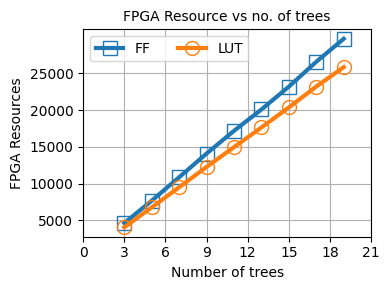

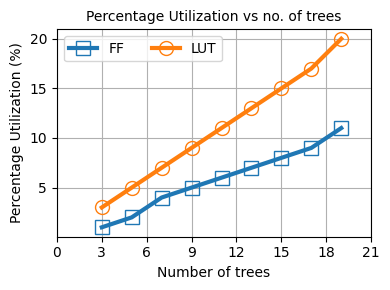

In [12]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(4, 3))
plt.plot(FPGA_build_logs.keys(), FFs.values(), marker = 's', markersize=10, fillstyle = 'none', linewidth=3, label = 'FF')
plt.plot(FPGA_build_logs.keys(), LUTs.values(), marker = 'o', markersize=10, fillstyle = 'none', linewidth=3, label = 'LUT')
plt.xlabel('Number of trees', size=10)
plt.ylabel('FPGA Resources', size=10)
plt.title('FPGA Resource vs no. of trees', size=10)
plt.grid()
plt.yticks([5000, 10000, 15000, 20000, 25000], size=10)
plt.xticks(range(0,22,3), size=10)
plt.legend(ncol=2, loc='upper left')
plt.tight_layout()
plt.savefig('fpgares_rf_MNIST.pdf')
plt.show()

figure(figsize=(4, 3))
plt.plot(FPGA_build_logs.keys(), FFs_Utilization.values(), marker = 's', markersize=10, fillstyle = 'none', linewidth=3, label = 'FF')
plt.plot(FPGA_build_logs.keys(), LUTs_Utilization.values(), marker = 'o', markersize=10, fillstyle = 'none', linewidth=3, label = 'LUT')
plt.xlabel('Number of trees', size=10)
plt.ylabel('Percentage Utilization (%)', size=10)
plt.title('Percentage Utilization vs no. of trees', size=10)
plt.grid()
plt.yticks([5, 10, 15, 20], size=10)
plt.xticks(range(0,22,3), size=10)
plt.legend(ncol=2, loc='upper left')
plt.tight_layout()
plt.savefig('fpgarespers_rf_MNIST.pdf')
plt.show()

##### Deeper trees

In [13]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_predict
train_acc = {}
val_acc = {}
nodes_count = {}
leaves_count = {}
rf_clf = {}
for n_tree in range(3,20,2):
    for depth in range(5,12,2):
        print(f'Testing for {(n_tree,depth)}.')
        rf_clf[(n_tree,depth)] = RandomForestClassifier(n_estimators=n_tree, max_depth=depth)

        y_train_pred = cross_val_predict(rf_clf[(n_tree,depth)], X_train, y_train, cv=2)
        rf_clf[(n_tree,depth)].fit( X_train, y_train)

        from sklearn.model_selection import cross_val_score
        train_acc[(n_tree,depth)] = np.mean(cross_val_score(rf_clf[(n_tree,depth)], X_train, y_train, cv=2, scoring="accuracy"))
        val_acc[(n_tree,depth)] = np.mean(cross_val_score(rf_clf[(n_tree,depth)], X_test, y_test, cv=2, scoring="accuracy"))
        nodes_count[(n_tree,depth)] = [tree_i.tree_.node_count for tree_i in rf_clf[(n_tree,depth)].estimators_]
        leaves_count[(n_tree,depth)] = [tree_i.tree_.n_leaves for tree_i in rf_clf[(n_tree,depth)].estimators_]

Testing for (3, 5).
Testing for (3, 7).
Testing for (3, 9).
Testing for (3, 11).
Testing for (5, 5).
Testing for (5, 7).
Testing for (5, 9).
Testing for (5, 11).
Testing for (7, 5).
Testing for (7, 7).
Testing for (7, 9).
Testing for (7, 11).
Testing for (9, 5).
Testing for (9, 7).
Testing for (9, 9).
Testing for (9, 11).
Testing for (11, 5).
Testing for (11, 7).
Testing for (11, 9).
Testing for (11, 11).
Testing for (13, 5).
Testing for (13, 7).
Testing for (13, 9).
Testing for (13, 11).
Testing for (15, 5).
Testing for (15, 7).
Testing for (15, 9).
Testing for (15, 11).
Testing for (17, 5).
Testing for (17, 7).
Testing for (17, 9).
Testing for (17, 11).
Testing for (19, 5).
Testing for (19, 7).
Testing for (19, 9).
Testing for (19, 11).


In [14]:
import pickle
with open('rf_clf_mnist.pickle', 'wb') as handle:
    pickle.dump(rf_clf, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [26]:
print('Training accuracy: ',train_acc)
print('======================')
print('Testing accuracy: ',val_acc)
print('======================')
print('Nodes count: ',nodes_count)
print('======================')
print('Leaves count: ',leaves_count)

Training accuracy:  {(3, 5): 0.7060119047619048, (3, 7): 0.8014285714285714, (3, 9): 0.8356845238095238, (3, 11): 0.8416071428571429, (5, 5): 0.7583035714285715, (5, 7): 0.8342261904761905, (5, 9): 0.8747916666666666, (5, 11): 0.8879166666666667, (7, 5): 0.7754166666666666, (7, 7): 0.8599107142857143, (7, 9): 0.8917559523809524, (7, 11): 0.9020833333333333, (9, 5): 0.8074404761904762, (9, 7): 0.8722619047619047, (9, 9): 0.9017559523809524, (9, 11): 0.9163988095238096, (11, 5): 0.8093452380952382, (11, 7): 0.8786904761904761, (11, 9): 0.9079761904761905, (11, 11): 0.9230952380952382, (13, 5): 0.815952380952381, (13, 7): 0.884375, (13, 9): 0.9118154761904762, (13, 11): 0.9262797619047619, (15, 5): 0.8274702380952381, (15, 7): 0.883720238095238, (15, 9): 0.9104166666666667, (15, 11): 0.9311904761904761, (17, 5): 0.8276488095238095, (17, 7): 0.8866369047619047, (17, 9): 0.9168154761904762, (17, 11): 0.9321428571428572, (19, 5): 0.8328571428571429, (19, 7): 0.8882738095238095, (19, 9): 0.92

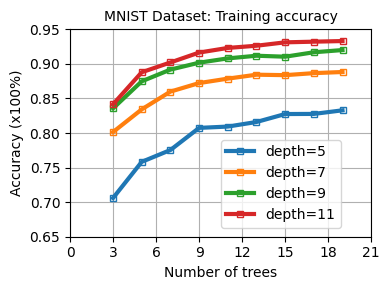

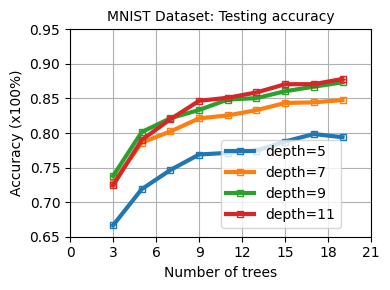

In [27]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(4, 3))
for depth in np.unique([i[1] for i in train_acc.keys()]):
    plt.plot(np.unique([i[0] for i in train_acc.keys()]), [train_acc[j,depth] for j in np.unique([i[0] for i in train_acc.keys()])], marker = 's', markersize=5, fillstyle = 'none', linewidth=3, label = 'depth='+str(depth))
    #plt.plot(np.unique([i[0] for i in val_acc.keys()]), [val_acc[j,depth] for j in np.unique([i[0] for i in val_acc.keys()])], marker = 's', markersize=5, fillstyle = 'none', linewidth=3, label = 'depth='+str(depth))
plt.xlabel('Number of trees', size=10)
plt.ylabel('Accuracy (x100%)', size=10)
plt.title('MNIST Dataset: Training accuracy', size=10)
plt.grid()
plt.yticks([0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95], size=10)
plt.xticks(range(0,22,3), size=10)
plt.legend(ncol=1, bbox_to_anchor=(0.70, 0.01), loc='lower center')
plt.tight_layout()
plt.savefig('accuracy_rf_MNIST_train.pdf')
plt.show()

figure(figsize=(4, 3))
for depth in np.unique([i[1] for i in train_acc.keys()]):
    plt.plot(np.unique([i[0] for i in val_acc.keys()]), [val_acc[j,depth] for j in np.unique([i[0] for i in val_acc.keys()])], marker = 's', markersize=5, fillstyle = 'none', linewidth=3, label = 'depth='+str(depth))
plt.xlabel('Number of trees', size=10)
plt.ylabel('Accuracy (x100%)', size=10)
plt.title('MNIST Dataset: Testing accuracy', size=10)
plt.grid()
plt.yticks([0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95], size=10)
plt.xticks(range(0,22,3), size=10)
plt.legend(ncol=1, bbox_to_anchor=(0.70, 0.01), loc='lower center')
plt.tight_layout()
plt.savefig('accuracy_rf_MNIST_test.pdf')
plt.show()

##### FPGA Resource Utilization

In [7]:
import pickle
with open('rf_clf_mnist.pickle', 'rb') as handle:
    rf_clf_mnist = pickle.load(handle)

for n_tree in np.unique([i[0] for i in rf_clf_mnist.keys()]):
    for depth in np.unique([i[1] for i in rf_clf_mnist.keys()]): 
        for i,dt in enumerate(rf_clf_mnist[(n_tree,depth)].estimators_):
            for j,thd in enumerate(dt.tree_.threshold):
                rf_clf_mnist[(n_tree,depth)].estimators_[i].tree_.threshold[j] = ciphertexts[int(round(thd))]
FPGA_build_logs = {}

In [8]:
HLS_bild_error= []
for n_tree in np.unique([i[0] for i in rf_clf_mnist.keys()]):
    for depth in np.unique([i[1] for i in rf_clf_mnist.keys()]):
        for i in rf_clf_mnist[(n_tree,depth)].classes_:
            rf_clf_mnist[(n_tree,depth)].classes_[i] = ciphertexts[i]
        print(f'Building for RF with (n_tree,depth) = {(n_tree,depth)}.')
        cfg = conifer.backends.xilinxhls.auto_config()
        # Set the output directory to something unique
        cfg['OutputDir'] = f'model_McElieceMNIST_RFtree_{n_tree}_{depth}/conifer_prj'
        cfg['XilinxPart'] = 'xc7a200tfbg676-2'   #Artix-7 FPGA
        cfg['Precision'] = 'ap_fixed<16,16>'
        print(cfg)
        # Create and compile the model
        try:
            model = conifer.converters.convert_from_sklearn(rf_clf_mnist[(n_tree,depth)], cfg)
            model.compile()
            model.build()
            f=open(cfg['OutputDir'] + '/my_prj_prj/solution1/syn/report/my_prj_csynth.rpt','r')
            FPGA_build_logs[(n_tree,depth)] = f.read()    
            f.close()
        except:
            print('FPGA resource error in :', (n_tree,depth))
            HLS_bild_error.append([n_tree,depth]) 

Building for RF with (n_tree,depth) = (3, 5).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_3_5/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (3, 7).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_3_7/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (3, 9).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_3_9/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (3, 11).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_3_11/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'P

build failed, check logs


FPGA resource error in : (3, 11)
Building for RF with (n_tree,depth) = (5, 5).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_5_5/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (5, 7).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_5_7/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (5, 9).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_5_9/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (5, 11).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_5_11/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'Cloc

build failed, check logs


FPGA resource error in : (5, 11)
Building for RF with (n_tree,depth) = (7, 5).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_7_5/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (7, 7).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_7_7/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (7, 9).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_7_9/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}


build failed, check logs


FPGA resource error in : (7, 9)
Building for RF with (n_tree,depth) = (7, 11).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_7_11/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}


build failed, check logs


FPGA resource error in : (7, 11)
Building for RF with (n_tree,depth) = (9, 5).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_9_5/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (9, 7).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_9_7/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (9, 9).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_9_9/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}


build failed, check logs


FPGA resource error in : (9, 9)
Building for RF with (n_tree,depth) = (9, 11).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_9_11/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}


build failed, check logs


FPGA resource error in : (9, 11)
Building for RF with (n_tree,depth) = (11, 5).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_11_5/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (11, 7).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_11_7/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (11, 9).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_11_9/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}


build failed, check logs


FPGA resource error in : (11, 9)
Building for RF with (n_tree,depth) = (11, 11).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_11_11/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}


build failed, check logs


FPGA resource error in : (11, 11)
Building for RF with (n_tree,depth) = (13, 5).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_13_5/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (13, 7).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_13_7/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (13, 9).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_13_9/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}


build failed, check logs


FPGA resource error in : (13, 9)
Building for RF with (n_tree,depth) = (13, 11).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_13_11/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}


build failed, check logs


FPGA resource error in : (13, 11)
Building for RF with (n_tree,depth) = (15, 5).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_15_5/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (15, 7).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_15_7/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (15, 9).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_15_9/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}


build failed, check logs


FPGA resource error in : (15, 9)
Building for RF with (n_tree,depth) = (15, 11).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_15_11/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}


build failed, check logs


FPGA resource error in : (15, 11)
Building for RF with (n_tree,depth) = (17, 5).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_17_5/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (17, 7).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_17_7/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (17, 9).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_17_9/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}


build failed, check logs


FPGA resource error in : (17, 9)
Building for RF with (n_tree,depth) = (17, 11).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_17_11/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}


build failed, check logs


FPGA resource error in : (17, 11)
Building for RF with (n_tree,depth) = (19, 5).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_19_5/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (19, 7).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_19_7/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}
Building for RF with (n_tree,depth) = (19, 9).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_19_9/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}


build failed, check logs


FPGA resource error in : (19, 9)
Building for RF with (n_tree,depth) = (19, 11).
{'Backend': 'xilinxhls', 'ProjectName': 'my_prj', 'OutputDir': 'model_McElieceMNIST_RFtree_19_11/conifer_prj', 'XilinxPart': 'xc7a200tfbg676-2', 'ClockPeriod': '5', 'Unroll': True, 'Precision': 'ap_fixed<16,16>'}


build failed, check logs


FPGA resource error in : (19, 11)


In [10]:
import pickle
with open('FPGA_build_logs_mnist.pickle', 'wb') as handle:
    pickle.dump(FPGA_build_logs, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [43]:
import pickle
with open('FPGA_build_logs_mnist.pickle', 'rb') as handle:
    FPGA_build_logs_mnist = pickle.load(handle)
print(FPGA_build_logs_mnist.keys())
FFs = {}
LUTs = {}
FFs_Utilization = {}
LUTs_Utilization = {}
clock_estimate = {}
clock_uncertanity = {}
for (n_tree,depth) in FPGA_build_logs_mnist.keys():
    for line in FPGA_build_logs_mnist[(n_tree,depth)].split('\n'):
        if '|Total            |' in line:
            line = line.split('0|      0|')[1].split('|')  #FF and LUTs
            FFs[(n_tree,depth)] = int(line[0].strip())
            LUTs[(n_tree,depth)] = int(line[1].strip())
        if '|Utilization (%)  |' in line:
            line = line.split('0|      0|')[1].split('|')
            FFs_Utilization[(n_tree,depth)] = int(line[0].strip())
            LUTs_Utilization[(n_tree,depth)] = int(line[1].strip())
        if '|ap_clk  |   5.00|' in line:
            line = line.split('|ap_clk  |   5.00|')[1].split('|')
            clock_estimate[(n_tree,depth)] = float(line[0].strip())
            clock_uncertanity[(n_tree,depth)] = float(line[1].strip())
            
print(f'\n\n FFs = {FFs},\n\n LUTs={LUTs},\n\n FFs_Utilization={FFs_Utilization},\n\n LUTs_Utilization={LUTs_Utilization}, \n\n clock_estimate={clock_estimate}, \n\n clock_uncertanity={clock_uncertanity}')

dict_keys([(3, 5), (3, 7), (3, 9), (5, 5), (5, 7), (5, 9), (7, 5), (7, 7), (9, 5), (9, 7), (11, 5), (11, 7), (13, 5), (13, 7), (15, 5), (15, 7), (17, 5), (17, 7), (19, 5), (19, 7)])


 FFs = {(3, 5): 4539, (3, 7): 28220, (3, 9): 0, (5, 5): 7792, (5, 7): 37504, (5, 9): 0, (7, 5): 10822, (7, 7): 37681, (9, 5): 14044, (9, 7): 47116, (11, 5): 17104, (11, 7): 47390, (13, 5): 20214, (13, 7): 56541, (15, 5): 23005, (15, 7): 75824, (17, 5): 24823, (17, 7): 112803, (19, 5): 29784, (19, 7): 103611},

 LUTs={(3, 5): 4012, (3, 7): 22779, (3, 9): 0, (5, 5): 6773, (5, 7): 30062, (5, 9): 0, (7, 5): 9501, (7, 7): 30425, (9, 5): 12266, (9, 7): 37685, (11, 5): 14901, (11, 7): 37688, (13, 5): 17587, (13, 7): 45265, (15, 5): 20281, (15, 7): 60487, (17, 5): 21709, (17, 7): 90510, (19, 5): 25840, (19, 7): 82857},

 FFs_Utilization={(3, 5): 1, (3, 7): 10, (3, 9): 0, (5, 5): 2, (5, 7): 13, (5, 9): 0, (7, 5): 4, (7, 7): 13, (9, 5): 5, (9, 7): 17, (11, 5): 6, (11, 7): 17, (13, 5): 7, (13, 7): 21, (15, 5): 8, (1

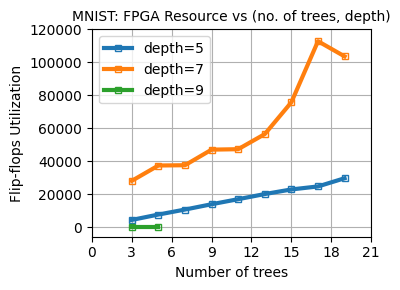

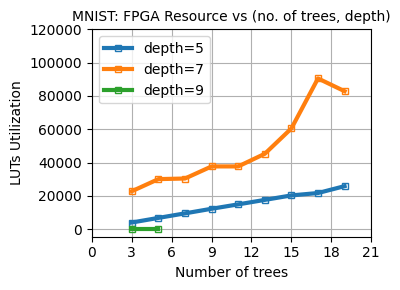

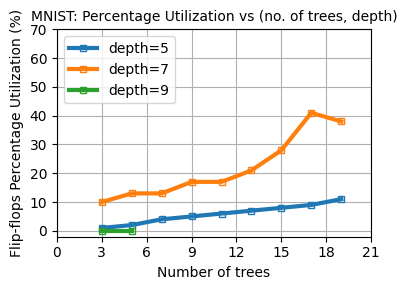

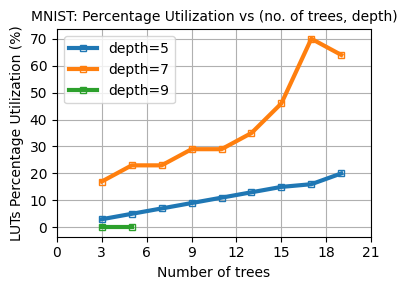

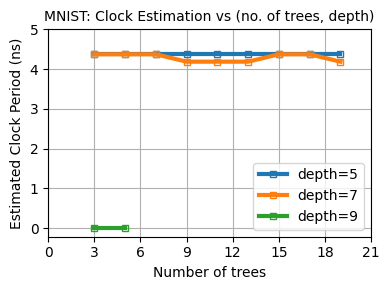

In [49]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(4, 3))
for depth in np.unique([i[1] for i in FFs.keys()]):
    fpga_res={}
    for n_tree in np.unique([i[0] for i in FFs.keys()]):
        try:
            fpga_res[n_tree] = FFs[(n_tree,depth)]
        except:
            pass
    plt.plot(fpga_res.keys(), fpga_res.values(), marker = 's', markersize=5, fillstyle = 'none', linewidth=3, label = 'depth='+str(depth))   
plt.xlabel('Number of trees', size=10)
plt.ylabel('Flip-flops Utilization', size=10)
plt.title('MNIST: FPGA Resource vs (no. of trees, depth)', size=10)
plt.grid()
plt.yticks([0, 20000, 40000, 60000, 80000, 100000, 120000], size=10)
plt.xticks(range(0,22,3), size=10)
plt.legend(ncol=1, loc='upper left')
plt.tight_layout()
plt.savefig('fpgares_rf_MNIST_ffs.pdf')
plt.show()

figure(figsize=(4, 3))
for depth in np.unique([i[1] for i in LUTs.keys()]):
    fpga_res={}
    for n_tree in np.unique([i[0] for i in LUTs.keys()]):
        try:
            fpga_res[n_tree] = LUTs[(n_tree,depth)]
        except:
            pass
    plt.plot(fpga_res.keys(), fpga_res.values(), marker = 's', markersize=5, fillstyle = 'none', linewidth=3, label = 'depth='+str(depth))   
plt.xlabel('Number of trees', size=10)
plt.ylabel('LUTs Utilization', size=10)
plt.title('MNIST: FPGA Resource vs (no. of trees, depth)', size=10)
plt.grid()
plt.yticks([0, 20000, 40000, 60000, 80000, 100000, 120000], size=10)
plt.xticks(range(0,22,3), size=10)
plt.legend(ncol=1, loc='upper left')
plt.tight_layout()
plt.savefig('fpgares_rf_MNIST_luts.pdf')
plt.show()

figure(figsize=(4, 3))
for depth in np.unique([i[1] for i in FFs_Utilization.keys()]):
    fpga_res={}
    for n_tree in np.unique([i[0] for i in FFs_Utilization.keys()]):
        try:
            fpga_res[n_tree] = FFs_Utilization[(n_tree,depth)]
        except:
            pass
    plt.plot(fpga_res.keys(), fpga_res.values(), marker = 's', markersize=5, fillstyle = 'none', linewidth=3, label = 'depth='+str(depth))   
plt.ylabel('Flip-flops Percentage Utilization (%)', size=10)
plt.title('MNIST: Percentage Utilization vs (no. of trees, depth)', size=10)
plt.xlabel('Number of trees', size=10)
plt.grid()
plt.yticks([0, 10, 20, 30, 40, 50, 60, 70], size=10)
plt.xticks(range(0,22,3), size=10)
plt.legend(ncol=1, loc='upper left')
plt.tight_layout()
plt.savefig('fpgarespers_rf_MNIST_ffs.pdf')
plt.show()

figure(figsize=(4, 3))
for depth in np.unique([i[1] for i in LUTs_Utilization.keys()]):
    fpga_res={}
    for n_tree in np.unique([i[0] for i in LUTs_Utilization.keys()]):
        try:
            fpga_res[n_tree] = LUTs_Utilization[(n_tree,depth)]
        except:
            pass
    plt.plot(fpga_res.keys(), fpga_res.values(), marker = 's', markersize=5, fillstyle = 'none', linewidth=3, label = 'depth='+str(depth))   
plt.ylabel('LUTs Percentage Utilization (%)', size=10)
plt.title('MNIST: Percentage Utilization vs (no. of trees, depth)', size=10)
plt.xlabel('Number of trees', size=10)
plt.grid()
plt.yticks([0, 10, 20, 30, 40, 50, 60, 70], size=10)
plt.xticks(range(0,22,3), size=10)
plt.legend(ncol=1, loc='upper left')
plt.tight_layout()
plt.savefig('fpgarespers_rf_MNIST_luts.pdf')
plt.show()

figure(figsize=(4, 3))
for depth in np.unique([i[1] for i in clock_estimate.keys()]):
    fpga_res={}
    for n_tree in np.unique([i[0] for i in clock_estimate.keys()]):
        try:
            fpga_res[n_tree] = clock_estimate[(n_tree,depth)]
        except:
            pass
    plt.plot(fpga_res.keys(), fpga_res.values(), marker = 's', markersize=5, fillstyle = 'none', linewidth=3, label = 'depth='+str(depth))   
plt.ylabel('Estimated Clock Period (ns)', size=10)
plt.title('MNIST: Clock Estimation vs (no. of trees, depth)', size=10)
plt.xlabel('Number of trees', size=10)
plt.grid()
plt.yticks([0, 1, 2, 3, 4, 5], size=10)
plt.xticks(range(0,22,3), size=10)
plt.legend(ncol=1, loc='lower right')
plt.tight_layout()
plt.savefig('fpgarespers_rf_MNIST_clock.pdf')
plt.show()